In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ISLP.models import (ModelSpec as MS,poly)
import ISLP

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn import metrics
from sklearn.feature_selection import f_regression
from pygam import ( s as s_gam,l as l_gam,f as f_gam,LinearGAM,LogisticGAM)
from pygam import GAM
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import SplineTransformer

In [3]:
from ISLP.transforms import (BSpline,NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,degrees_of_freedom,\
                        plot as plot_gam, anova as anova_gam)

In [4]:
from patsy import dmatrix
import itertools
import plotly
import cufflinks
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py

# Question 6

In [5]:
Wage=ISLP.load_data('Wage')
Wage[:2]

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020


In [6]:
y=Wage['wage']
X=Wage['age']
age_df=pd.DataFrame(data=np.linspace(X.min(),X.max(),100),columns=['age'])

## A

In [7]:
mse=[]
for i in range(1,11):
    scaler=StandardScaler()
    lin_reg=LinearRegression()
    polyn=PolynomialFeatures(degree=i)
    pipe=Pipeline([('poly',polyn),('scaler',scaler),('lin_reg',lin_reg)])
    poly_X=polyn.fit_transform(np.array(X).reshape(-1,1))
    mse.append(-cross_val_score(pipe,poly_X,y,scoring='neg_mean_squared_error').mean())
plt.plot(range(1,11),mse)
plt.xticks(range(1,11),range(1,11))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+1,c='g',ls='--')
plt.xlabel('Degree')
plt.ylabel('MSE');

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\preprocessing\_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\preprocessing\_data.py", line 999, in partial_fit
    self.mean_, self.var_, self.n_samples_seen_ = _incremental_mean_and_var(
                                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\anaconda3\envs\ISLP\Lib\site-packages\sklearn\utils\extmath.py", line 1143, in _incremental_mean_and_var
    temp = X - T
           ~~^~~
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 1.65 GiB for an array with shape (2400, 92378) and data type float64


In [ ]:
(np.asarray(X)[:,np.newaxis]== np.array(X).reshape(-1,1)).sum()

In [ ]:
'''for ANOVA testing'''
models=[]
for i in range(11):
    polyn=PolynomialFeatures(degree=i)
    poly_X=polyn.fit_transform(np.array(X).reshape(-1,1))
    model=sm.OLS(y,poly_X).fit()
    models.append(model)

sm.stats.anova_lm(*models[:7], typ=1)

In [ ]:
poly_X=MS([poly('age',degree=4)]).fit_transform(Wage)
res=sm.OLS(y,poly_X).fit()
pred=res.predict(poly_X)
sns.scatterplot(x=X,y=y)
plt.scatter(X,pred);

## B

In [ ]:
mse=[]
for i in range(1,16):
    scaler=StandardScaler()
    lin_reg=LinearRegression()
    polyn=PolynomialFeatures(degree=4)
    pipe=Pipeline([('poly',polyn),('lin_reg',lin_reg)])
    X_dummies=pd.get_dummies(pd.cut(X,bins=i))
    pipe.fit(X_dummies,y)
    mse.append(-(cross_val_score(pipe,X_dummies,y,scoring='neg_mean_squared_error').mean()))

In [ ]:
plt.plot(range(1,16),mse)
plt.xticks(range(1,16))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+1,c='g',ls='--')
plt.xlabel('Cuts')
plt.ylabel('MSE');

In [ ]:
scaler=StandardScaler()
lin_reg=LinearRegression()
polyn=PolynomialFeatures(degree=4)
pipe=Pipeline([('poly',polyn),('lin_reg',lin_reg)])
X_dummies=pd.get_dummies(pd.cut(X,bins=11))
pipe.fit(X_dummies,y)

In [ ]:
poly_X

In [ ]:
X_dummies

In [ ]:
X_pred_dummies

In [ ]:
X_pred_dummies=pd.get_dummies(pd.cut(X.sort_values(),bins=11))
pred=pipe.predict(X_pred_dummies)
sns.scatterplot(x=X,y=y)
plt.plot(X.sort_values(),pred,c='r',lw=3)

# Question 7

In [ ]:
sns.pairplot(Wage)

In [ ]:
Wage[:2]

In [ ]:
X1=pd.get_dummies(Wage['maritl'])
X1

In [ ]:
X1=MS(['maritl']).fit_transform(Wage)
X1

In [ ]:
sm.OLS(y,X1).fit().summary()

In [ ]:
mse=[]
for i in range(1,11):
    scaler=StandardScaler()
    lin_reg=LinearRegression()
    polyn=PolynomialFeatures(degree=i)
    pipe=Pipeline([('poly',polyn),('lin_reg',lin_reg)])
    mse.append(-cross_val_score(pipe,X1,y,scoring='neg_mean_squared_error').mean())
plt.plot(range(1,11),mse)
plt.xticks(range(1,11))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+1,c='g',ls='--')
plt.xlabel('Degree')
plt.ylabel('MSE');

In [ ]:
scaler=StandardScaler()
lin_reg=LinearRegression()
polyn=PolynomialFeatures(degree=4)
pipe=Pipeline([('poly',polyn),('lin_reg',lin_reg)])
pipe.fit(X1,y)

In [ ]:
pred=pipe.predict(X1)
print(np.unique(pred))
sns.scatterplot(x=Wage['maritl'],y=y)
plt.scatter(Wage['maritl'],pred);

# Quetion 8

In [106]:
Auto=ISLP.load_data('Auto').reset_index(drop=True)
Auto[:2]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1


In [8]:
Auto['horsepower'].unique()

array([130, 165, 150, 140, 198, 220, 215, 225, 190, 170, 160,  95,  97,
        85,  88,  46,  87,  90, 113, 200, 210, 193, 100, 105, 175, 153,
       180, 110,  72,  86,  70,  76,  65,  69,  60,  80,  54, 208, 155,
       112,  92, 145, 137, 158, 167,  94, 107, 230,  49,  75,  91, 122,
        67,  83,  78,  52,  61,  93, 148, 129,  96,  71,  98, 115,  53,
        81,  79, 120, 152, 102, 108,  68,  58, 149,  89,  63,  48,  66,
       139, 103, 125, 133, 138, 135, 142,  77,  62, 132,  84,  64,  74,
       116,  82], dtype=int64)

In [6]:
Auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 24.6 KB


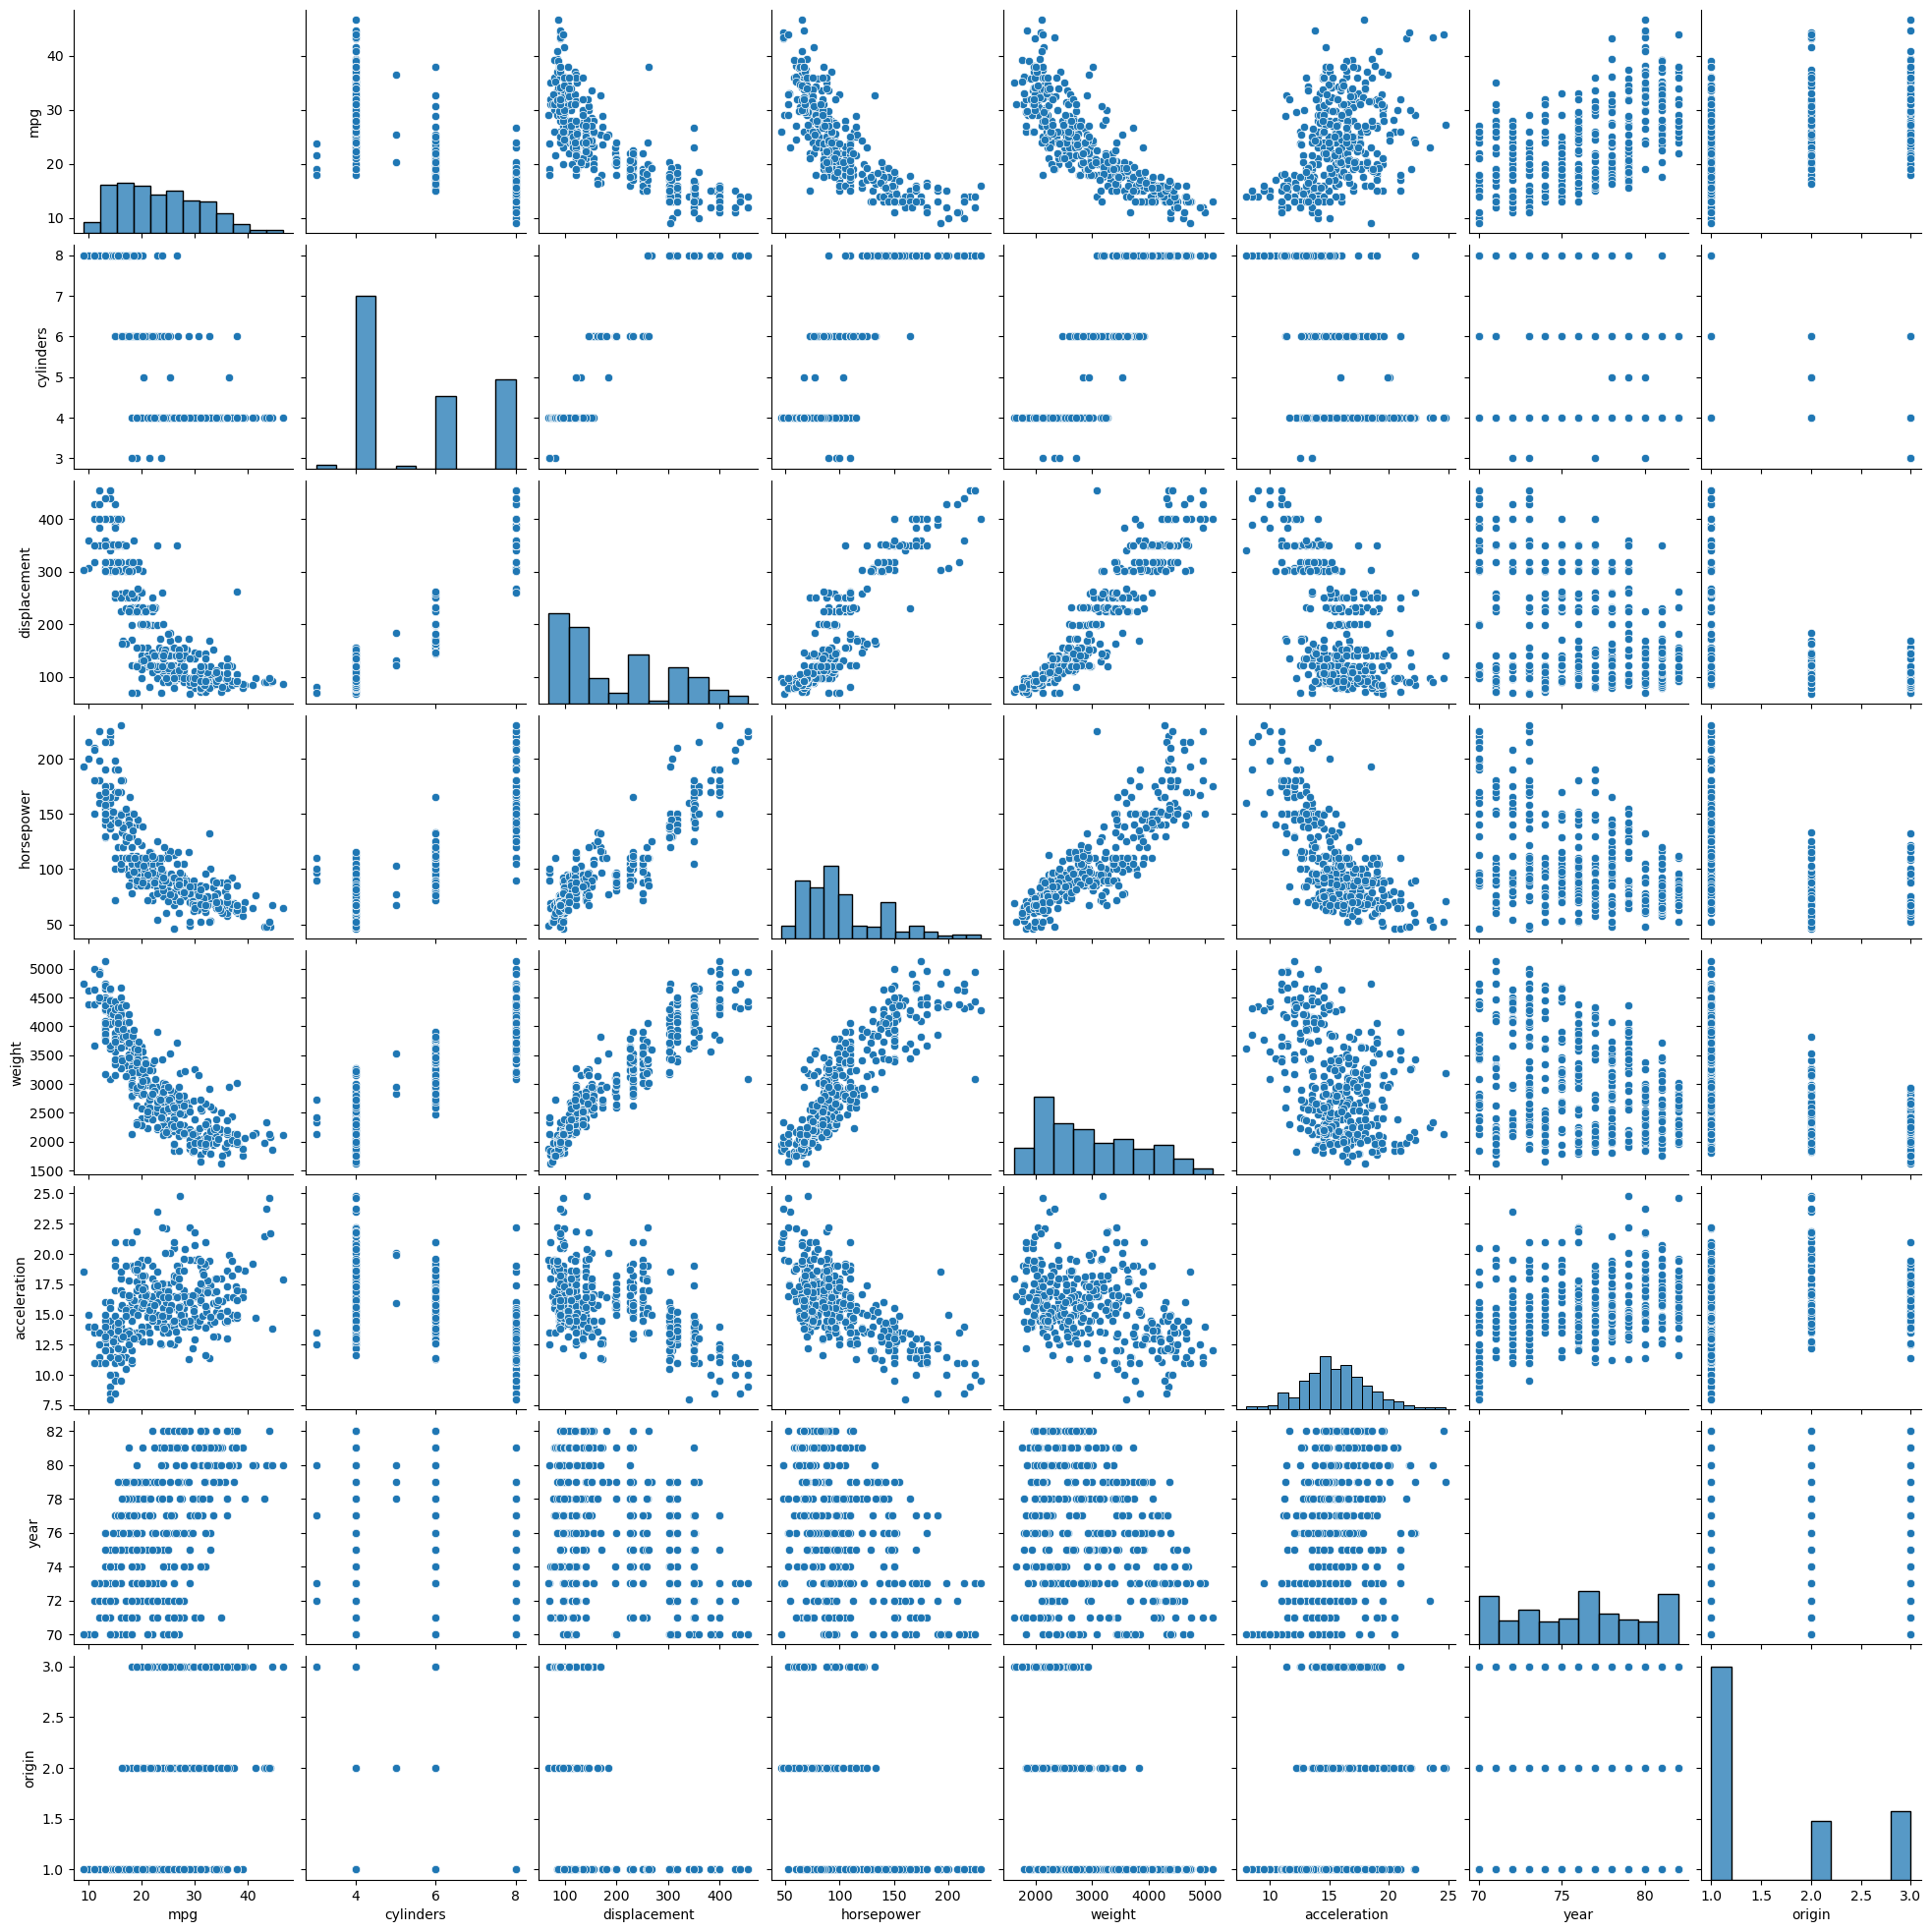

In [13]:
sns.pairplot(Auto)

In [107]:
X=Auto['horsepower']
y=Auto['mpg']
X_arr=np.asarray(X)[:,np.newaxis]

## Non-linear models

In [42]:
mse=[]
X_arr=np.array(X).reshape(-1,1)
# X_arr.shape
y_arr=np.array(y).reshape(-1,1)
# y.shape
for i in range(1,11):
    lin_reg=LinearRegression()
    polyn=PolynomialFeatures(degree=i)
    pipe=Pipeline([('polyn',polyn),('lin_reg',lin_reg)])
    mse.append(-cross_val_score(pipe,X_arr,y,scoring='neg_mean_squared_error',error_score='raise').mean())

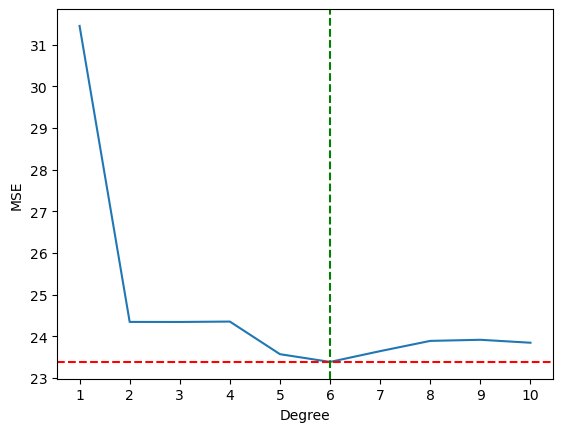

In [43]:
plt.plot(range(1,11),mse)
plt.xticks(range(1,11))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+1,c='g',ls='--')
plt.xlabel('Degree')
plt.ylabel('MSE');

In [44]:
'''for ANOVA testing'''
models=[]
for i in range(11):
    polyn=PolynomialFeatures(degree=i)
    poly_X=polyn.fit_transform(np.array(X).reshape(-1,1))
    model=sm.OLS(y,poly_X).fit()
    models.append(model)

sm.stats.anova_lm(*models, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,391.0,23818.993469,0.0,NaN,NaN,NaN
1,390.0,9385.915872,1.0,14433.077597,222.675310,3.729612e-40
2,389.0,7442.029412,1.0,1943.886460,29.990521,7.805495e-08
3,388.0,7426.436007,1.0,15.593405,0.240577,6.240670e-01
4,387.0,7399.522632,1.0,26.913375,0.415223,5.197121e-01
5,386.0,7223.371686,1.0,176.150946,2.717679,1.000559e-01
6,386.0,7246.187744,-0.0,-22.816058,inf,NaN
7,386.0,7241.387051,-0.0,4.800693,-inf,NaN
8,386.0,8594.560109,-0.0,-1353.173058,inf,NaN
9,386.0,13700.104374,-0.0,-5105.544265,inf,NaN


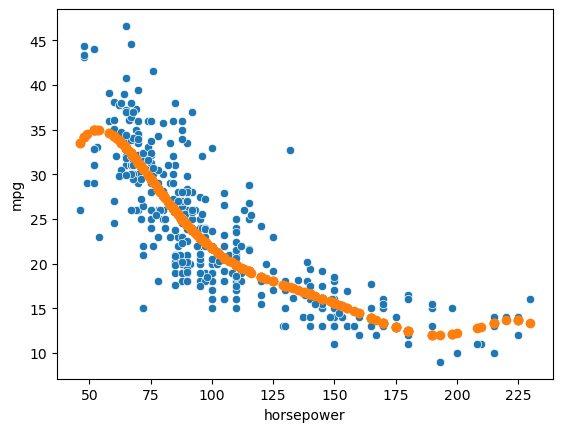

In [45]:
poly_X=MS([poly('horsepower',degree=6)]).fit_transform(Auto)
res=sm.OLS(y,poly_X).fit()
pred=res.predict(poly_X)
sns.scatterplot(x=X,y=y)
plt.scatter(X,pred);

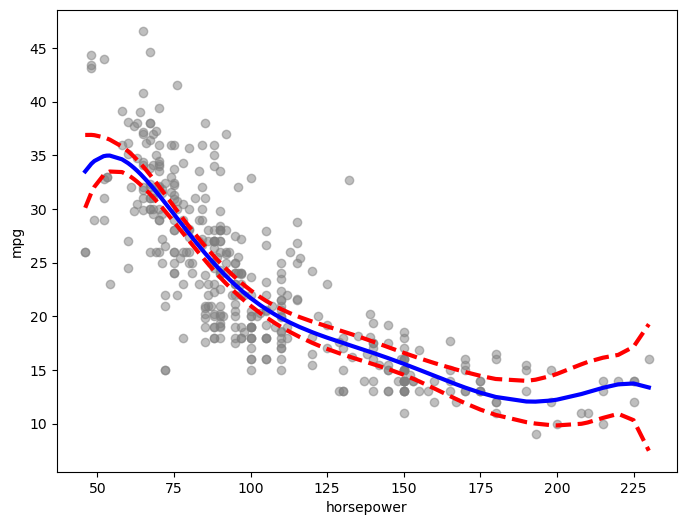

In [46]:
Auto_s=Auto.sort_values(by='horsepower')
poly_X=MS([poly('horsepower',degree=6)]).fit_transform(Auto_s)
res=sm.OLS(Auto_s['mpg'],poly_X).fit()
pred=res.get_prediction(poly_X)
bands = pred.conf_int(alpha =0.05)
fig , ax = plt.subplots(figsize =(8 ,6))
ax.scatter(X ,y,facecolor='gray',alpha =0.5)
for val , ls in zip([ pred.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
    ax.plot(Auto_s['horsepower'] , val , ls , linewidth =3)
# ax.set_title( , fontsize =20)
ax.set_xlabel('horsepower')
ax.set_ylabel('mpg');

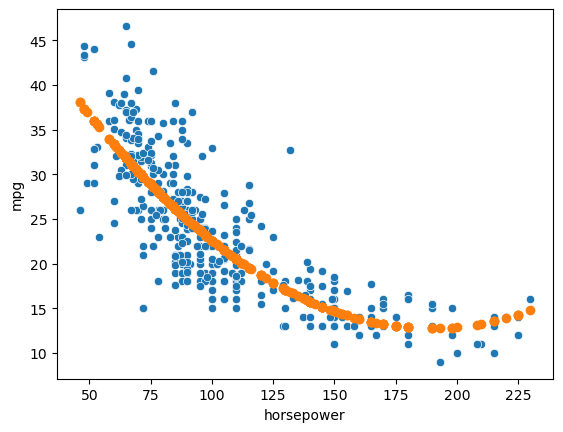

In [47]:
poly_X=MS([poly('horsepower',degree=2)]).fit_transform(Auto)
res=sm.OLS(y,poly_X).fit()
pred=res.predict(poly_X)
sns.scatterplot(x=X,y=y)
plt.scatter(X,pred);

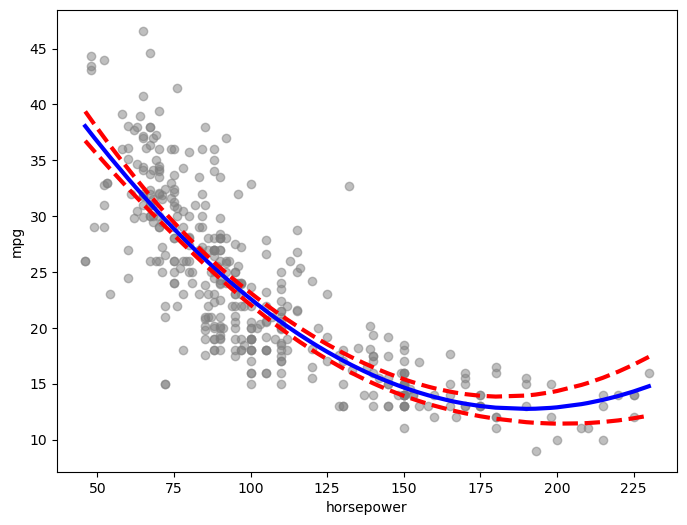

In [48]:
Auto_s=Auto.sort_values(by='horsepower')
poly_X=MS([poly('horsepower',degree=2)]).fit_transform(Auto_s)
res=sm.OLS(Auto_s['mpg'],poly_X).fit()
pred=res.get_prediction(poly_X)
bands = pred.conf_int(alpha =0.05)
fig , ax = plt.subplots(figsize =(8 ,6))
ax.scatter(X ,y,facecolor='gray',alpha =0.5)
for val , ls in zip([ pred.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
    ax.plot(Auto_s['horsepower'] , val , ls , linewidth =3)
# ax.set_title( , fontsize =20)
ax.set_xlabel('horsepower')
ax.set_ylabel('mpg');

## Step function

In [49]:
mse=[]
for i in range(1,16):
    lin_reg=LinearRegression()
    polyn=PolynomialFeatures(degree=6)
    pipe=Pipeline([('poly',polyn),('lin_reg',lin_reg)])
    X_dummies=pd.get_dummies(pd.cut(X,bins=i))
    mse.append(-cross_val_score(pipe,X_dummies,y,scoring='neg_mean_squared_error').mean())

In [50]:
mse

[73.92487276173405,
 45.54591984426908,
 40.96698654831512,
 28.45473173422413,
 28.840235527833453,
 27.298703902787178,
 26.184839323297023,
 23.39677881976174,
 25.243148471771605,
 26.470995792169767,
 24.98423833045848,
 6.142031902733007e+26,
 25.29417880761116,
 24.78902229809784,
 24.15998466261669]

In [51]:
mse[11]=100

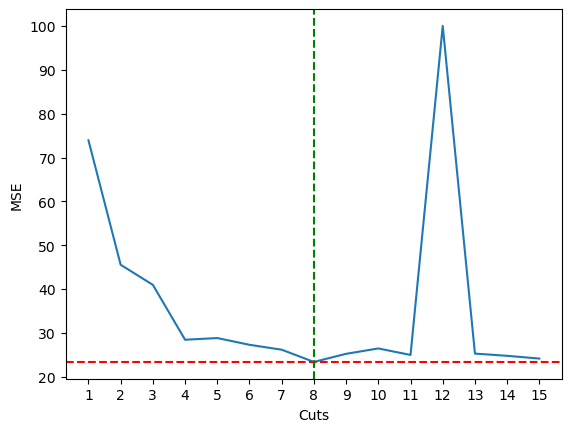

In [52]:
plt.plot(range(1,16),mse)
plt.xticks(range(1,16))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+1,c='g',ls='--')
plt.xlabel('Cuts')
plt.ylabel('MSE');

In [53]:
lin_reg=LinearRegression()
polyn=PolynomialFeatures(degree=6)
pipe=Pipeline([('poly',polyn),('lin_reg',lin_reg)])
X_dummies=pd.get_dummies(pd.cut(X,bins=8))
pipe.fit(X_dummies,y)

Pipeline(steps=[('poly', PolynomialFeatures(degree=6)),
                ('lin_reg', LinearRegression())])

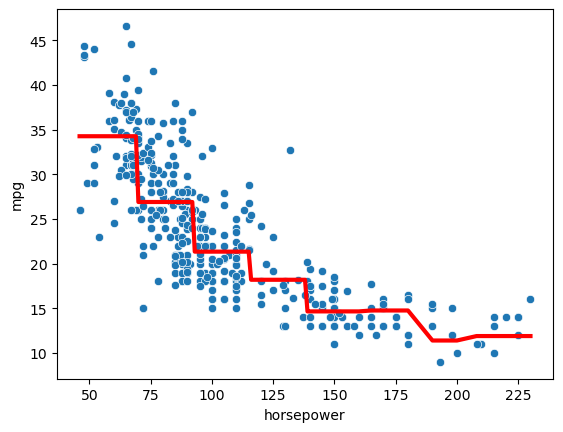

In [54]:
X_dummies=pd.get_dummies(pd.cut(X.sort_values(),bins=8))
pred=pipe.predict(X_dummies)
sns.scatterplot(x=X,y=y)
sns.lineplot(x=X.sort_values(),y=pred,color='red',linewidth=3);

## Regression splines

### Natural Cubic Splines

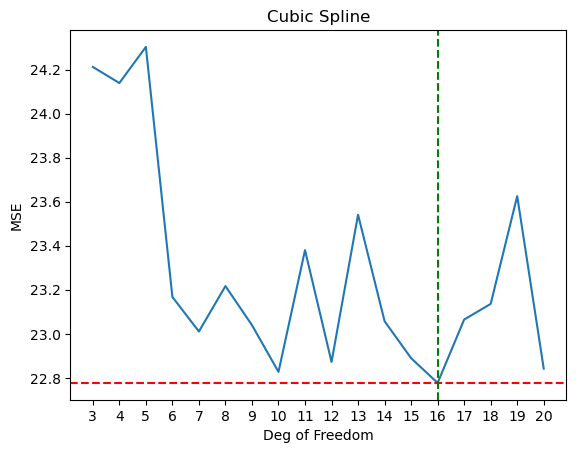

In [8]:
mse=[]
for i in range(3,21):  # The degrees of freedom can't be less than 3 in a cubic spline
    transformed = dmatrix("cr(Auto.horsepower, df=%i)" % i,{"Auto.horsepower":Auto.horsepower},
                          return_type='dataframe')  # Cubic spline basis representation
    lin = LinearRegression()
    lin.fit(transformed, y)
    mse.append(-cross_val_score(lin,transformed,y,scoring='neg_mean_squared_error').mean())
plt.plot(range(3,21),mse)
plt.xticks(range(3,21))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+3,c='g',ls='--')
plt.xlabel('Deg of Freedom')
plt.ylabel('MSE')
plt.title('Cubic Spline');

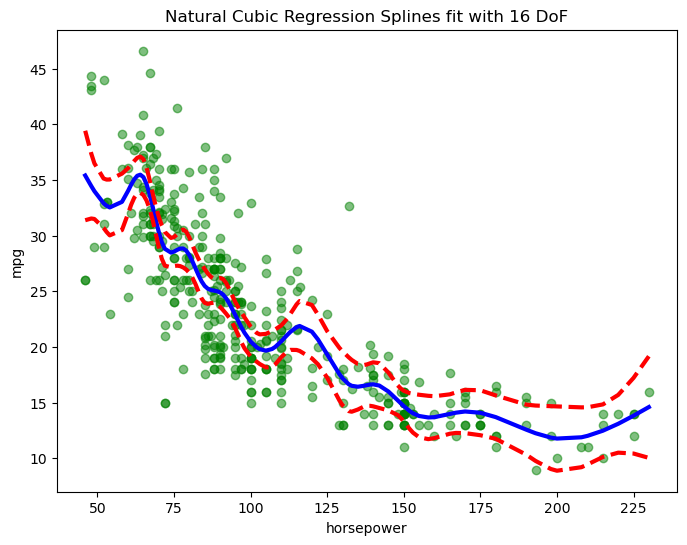

In [9]:
Auto_s=Auto.sort_values(by='horsepower')
transformed=dmatrix("cr(Auto.horsepower, df=16)",{"Auto.horsepower":Auto.horsepower},
                          return_type='dataframe')
res=sm.OLS(y,transformed).fit()
pred_X = dmatrix("cr(Auto_s.horsepower, df=16)",{"Auto_s.horsepower":Auto_s.horsepower},
                          return_type='dataframe')
pred=res.get_prediction(pred_X)
bands = pred.conf_int(alpha =0.05)
fig , ax = plt.subplots(figsize =(8 ,6))
ax.scatter(X ,y,facecolor='green',alpha =0.5)
for val , ls in zip([ pred.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
    ax.plot(Auto_s['horsepower'] , val , ls , linewidth =3)
ax.set_title('Natural Cubic Regression Splines fit with 16 DoF' )
ax.set_xlabel('horsepower')
ax.set_ylabel('mpg');

### Basis Splines

In [67]:
Auto.horsepower.isna().sum()

0

In [187]:
sample_data = pd.DataFrame({'horsepower': np.random.randint(50, 200, size=100)})
dmatrix("bs(horsepower, df=3, degree=3)", {"horsepower": np.asarray(sample_data['horsepower'])}, return_type='dataframe',NA_action='drop')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [188]:
i=8
dmatrix("bs(Auto.horsepower, df=%i, degree=3)" % i,{"Auto.horsepower":Auto.horsepower},return_type='dataframe')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [11]:
mse=[]
for i in range(3,21):  # The degrees of freedom can't be less than 3 in a cubic spline
    transformed = dmatrix("bs(Auto.horsepower, df=%i, degree=3)" % i,{"Auto.horsepower":Auto.horsepower},
                          return_type='dataframe')  # Cubic spline basis representation
    lin = LinearRegression()
    lin.fit(transformed, y)
    mse.append(-cross_val_score(lin,transformed,y,scoring='neg_mean_squared_error').mean())

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [ ]:
plt.plot(range(3,21),mse)
plt.xticks(range(3,21))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+3,c='g',ls='--')
plt.xlabel('Deg of Freedom')
plt.ylabel('MSE');

In [61]:
transformed = dmatrix("bs(Auto.horsepower, df=12, degree=3)",{"Auto.horsepower":Auto.horsepower},
                          return_type='dataframe')  # Cubic spline basis representation
lin = LinearRegression()
lin.fit(transformed, y)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [40]:
Auto_s=Auto.sort_values(by='horsepower')
res=sm.OLS(y,transformed).fit()
pred_X = dmatrix("bs(Auto_s.horsepower, df=12, degree=3)",{"Auto_s.horsepower":Auto_s.horsepower},
                          return_type='dataframe')
pred=res.get_prediction(pred_X)
bands = pred.conf_int(alpha =0.05)
fig , ax = plt.subplots(figsize =(8 ,6))
ax.scatter(X ,y,facecolor='green',alpha =0.5)
for val , ls in zip([ pred.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
    ax.plot(Auto_s['horsepower'] , val , ls , linewidth =3)
ax.set_title('Basis Spline fit with 12 DoF' )
ax.set_xlabel('horsepower')
ax.set_ylabel('mpg');

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

### Cyclic Cubic Regression Splines

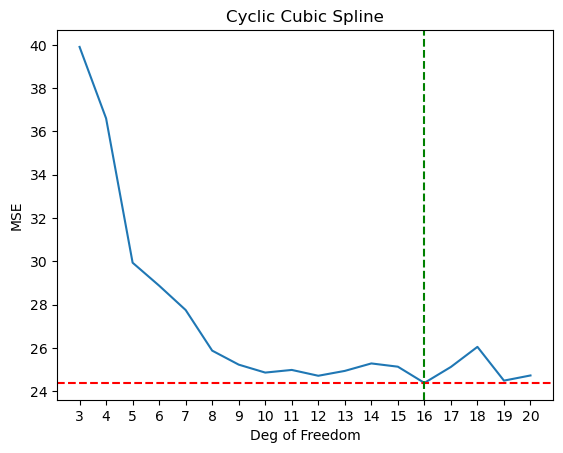

In [13]:
mse=[]
for i in range(3,21):  # The degrees of freedom can't be less than 3 in a cubic spline
    transformed = dmatrix("cc(Auto.horsepower, df=%i)" % i,{"Auto.horsepower":Auto.horsepower},
                          return_type='dataframe')  # Cubic spline basis representation
    lin = LinearRegression()
    lin.fit(transformed, y)
    mse.append(-cross_val_score(lin,transformed,y,scoring='neg_mean_squared_error').mean())
plt.plot(range(3,21),mse)
plt.xticks(range(3,21))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+3,c='g',ls='--')
plt.xlabel('Deg of Freedom')
plt.ylabel('MSE')
plt.title('Cyclic Cubic Spline');

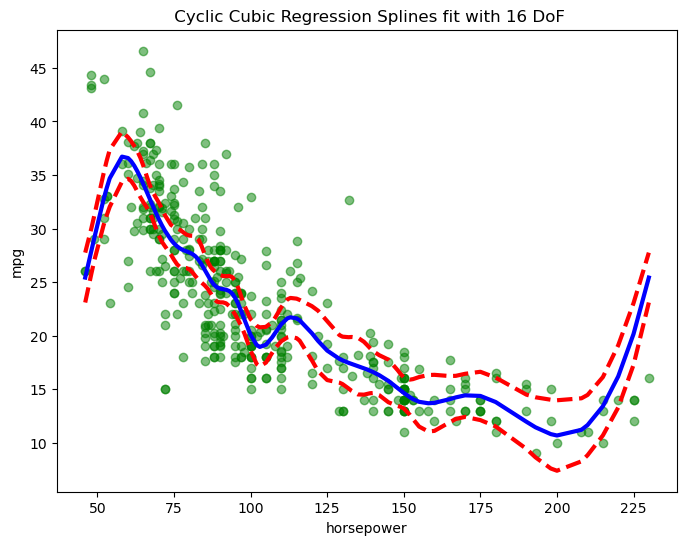

In [14]:
Auto_s=Auto.sort_values(by='horsepower')
transformed=dmatrix("cc(Auto.horsepower, df=16)",{"Auto.horsepower":Auto.horsepower},
                          return_type='dataframe')
res=sm.OLS(y,transformed).fit()
pred_X = dmatrix("cc(Auto_s.horsepower, df=16)",{"Auto_s.horsepower":Auto_s.horsepower},
                          return_type='dataframe')
pred=res.get_prediction(pred_X)
bands = pred.conf_int(alpha =0.05)
fig , ax = plt.subplots(figsize =(8 ,6))
ax.scatter(X ,y,facecolor='green',alpha =0.5)
for val , ls in zip([ pred.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
    ax.plot(Auto_s['horsepower'] , val , ls , linewidth =3)
ax.set_title(' Cyclic Cubic Regression Splines fit with 16 DoF' )
ax.set_xlabel('horsepower')
ax.set_ylabel('mpg');

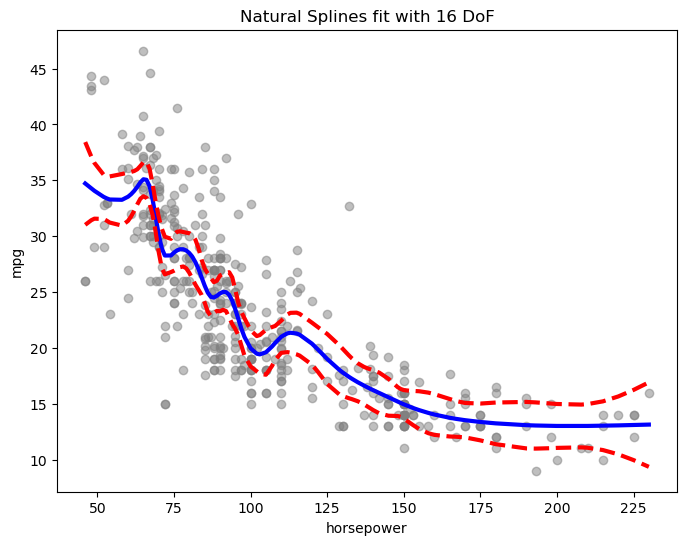

In [15]:
ns_horsepower = MS([ns('horsepower', df=16)]).fit(Auto)
res = sm.OLS(y, ns_horsepower.transform(Auto)).fit()
# print(X)
Auto_s=Auto.sort_values(by='horsepower')
Xnew = ns_horsepower.transform(Auto_s)
preds = res.get_prediction(Xnew)
bands = preds.conf_int(alpha =0.05)
fig , ax = plt.subplots(figsize =(8 ,6))
ax.scatter(X ,y,facecolor='gray',alpha =0.5)
for val , ls in zip([ preds.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
    ax.plot(Auto_s['horsepower'] , val , ls , linewidth =3)
ax.set_title('Natural Splines fit with 16 DoF' )
ax.set_xlabel('horsepower')
ax.set_ylabel('mpg');

## Smoothing Splines

### Smoothing Splines fit using GAM

In [10]:
X_arr=np.asarray(X)[:,np.newaxis]

In [10]:
gam=LinearGAM(s_gam(0,lam=0.6))
gam.fit(X_arr,y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

<Axes: xlabel='horsepower', ylabel='mpg'>

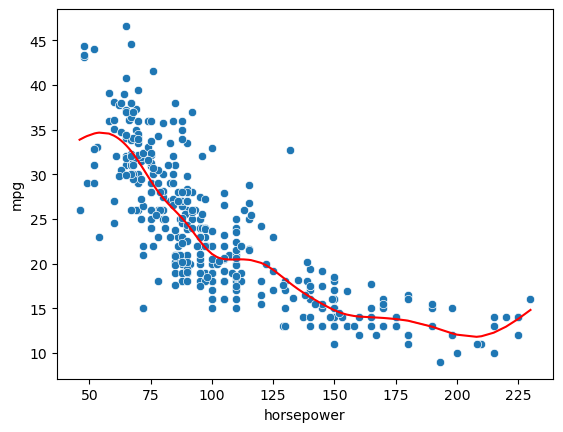

In [11]:
fig,ax=plt.subplots()
sns.scatterplot(x=X,y=y,ax=ax)
pred=gam.predict(X_arr)
pred.shape,X_arr.shape
sns.lineplot(ax=ax,x=X,y=pred,color='red')

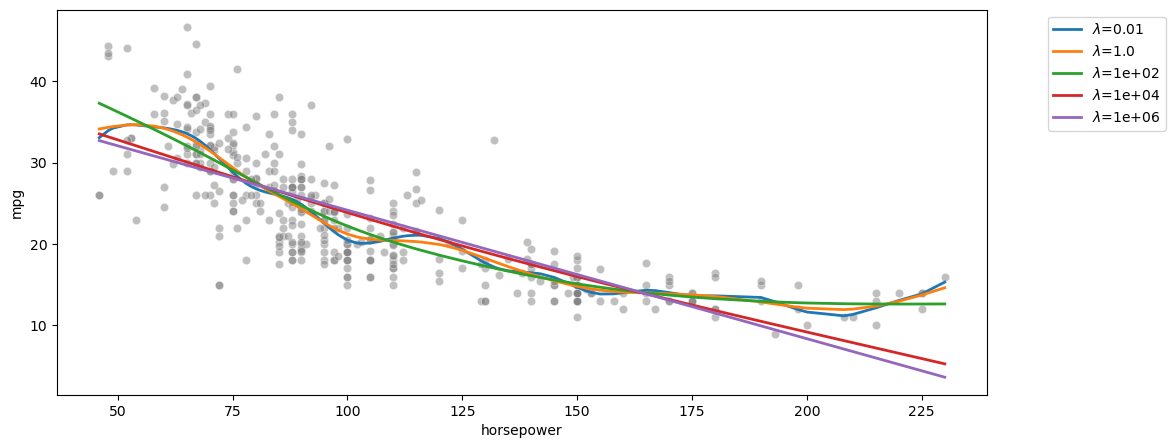

In [15]:
fig,ax=plt.subplots(figsize=(12,5))
sns.scatterplot(x=X,y=y,ax=ax,color='grey',alpha=0.5)
for i in np.logspace(-2,6,5):
    gam=LinearGAM(s_gam(0,lam=i))
    gam.fit(X_arr,y)
    pred=gam.predict(X_arr)
    sns.lineplot(ax=ax,x=X,y=pred,lw=2,label=r"$\lambda$="+f"{i:.2}")
plt.legend(loc=1,bbox_to_anchor=(1.20,1));

In [34]:
d

In [11]:
d=(gam.gridsearch(X_arr,y,return_scores=True))
pd.DataFrame(data=d.values(),index=d.keys())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


,0
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",20.348968
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",20.233795
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",20.045268
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",19.790032
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",19.509949
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",19.294938
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",19.163615
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",19.141224
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",19.224000
"LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, \n max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, \n verbose=False)",19.315731


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


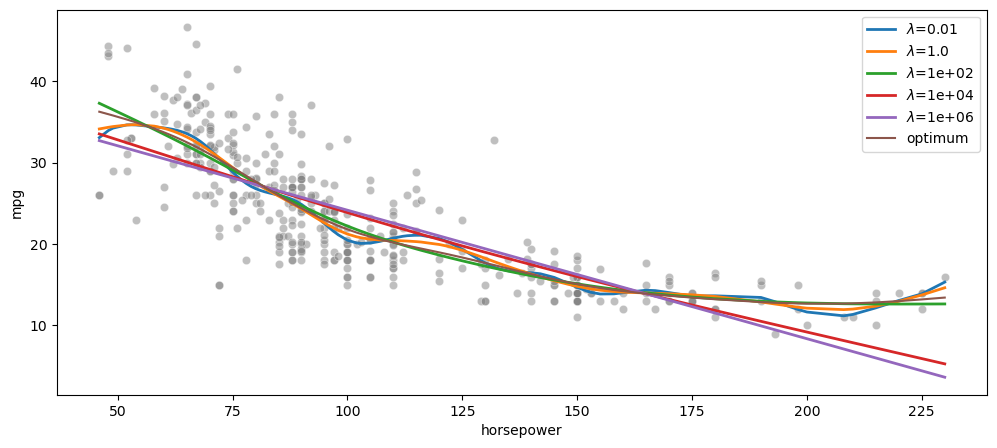

In [16]:
gam=LinearGAM(s_gam(0))
gam_optimum=gam.gridsearch(X_arr,y)
pred=gam_optimum.predict(X_arr)
sns.lineplot(ax=ax,x=X,y=pred,label='optimum')
ax.legend()
fig

In [12]:
gam=LinearGAM(s_gam(0))
gam_optimum=gam.gridsearch(X_arr,y)
gam_optimum.coef_,gam_optimum.logs_,
gam_optimum.statistics_,gam_optimum.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.5961
Link Function:                     IdentityLink Log Likelihood:                                 -1515.6903
Number of Samples:                          392 AIC:                                             3046.5728
                                                AICc:                                            3046.9134
                                                GCV:                                               19.1412
                                                Scale:                                             18.5624
                                                Pseudo R-Squared:                                   0.6997
Feature Function                  Lam

C:\Users\SHANTANU SRIVASTAV\AppData\Local\Temp\ipykernel_12320\1742342910.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_optimum.statistics_,gam_optimum.summary()


({'n_samples': 392,
  'm_features': 1,
  'edof_per_coef': array([4.56634864e-01, 2.94262380e-01, 4.44181438e-01, 4.13134590e-01,
         4.30048886e-01, 4.53786730e-01, 4.09923688e-01, 3.46971160e-01,
         2.55470549e-01, 3.06241663e-01, 5.14544207e-01, 1.98940610e-01,
         3.42110522e-01, 2.88536205e-01, 2.49726973e-01, 1.75760132e-01,
         3.17427148e-01, 5.01251359e-01, 1.93009840e-01, 4.11752871e-03,
         3.11933878e-22]),
  'edof': 6.5960804716576655,
  'scale': 18.56235393587941,
  'cov': array([[ 2.49646885,  1.52959301,  0.59481981, -0.07547413, -0.28772473,
          -0.22333772, -0.13932056, -0.11240023, -0.11954087, -0.13536041,
          -0.14847573, -0.15992769, -0.17592323, -0.20230435, -0.24434941,
          -0.30622287, -0.38915471, -0.48938733, -0.59822204, -0.70807342,
           0.10568332],
         [ 1.52959301,  0.99154945,  0.46682513,  0.06280471, -0.10587038,
          -0.10287922, -0.06391106, -0.04768072, -0.05045117, -0.05899147,
          -

#### Other method (Not sure about result) <-- inconsistent with above method

In [59]:
gam = GAM(s_gam(0))
param_grid = {'lam': np.logspace(0, 3, 110)}
grid_search = GridSearchCV(estimator=gam, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=GAM(callbacks=['deviance', 'diffs'], distribution='normal', 
   fit_intercept=True, link='identity', max_iter=100, terms=s(0), 
   tol=0.0001, verbose=False),
             param_grid={'lam': array([   1.        ,    1.06542513,    1.13513071,    1.20939678,
          1.28852172,    1.37282342,    1.46264057,    1.55833401,
          1.66028822,    1.76891279,    1.88464414,    2.00794722,
          2.13931743,    2.27928255,    2.4284049...
        205.08155677,  218.49904407,  232.79437221,  248.02497404,
        264.25203995,  281.54076375,  299.96060453,  319.58556576,
        340.49449262,  362.77138871,  386.50575361,  411.79294238,
        438.73454875,  467.43881319,  498.02105782,  530.60414976,
        565.31899469,  602.30506283,  641.71094925,  683.69497086,
        728.42580251,  776.08315459,  826.85849507,  880.95581875,
        938.59246681, 1000.        ])},
             scoring='neg_mean_squared_error')

In [60]:
grid_search.best_params_

{'lam': 1.0}

## GAM 

### Natural Spline

In [8]:
spline_transformer = SplineTransformer(degree=3, n_knots=2, knots='quantile', extrapolation='linear')
X_spline = spline_transformer.fit_transform(X_arr)
X_spline.shape
gam = LinearGAM().fit(X_spline, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.0154
Link Function:                     IdentityLink Log Likelihood:                                 -1500.4816
Number of Samples:                          392 AIC:                                              3040.994
                                                AICc:                                            3043.2617
                                                GCV:                                               19.5525
                                                Scale:                                              17.853
                                                Pseudo R-Squared:                                   0.7204
Feature Function                  Lam

C:\Users\SHANTANU SRIVASTAV\AppData\Local\Temp\ipykernel_188\2018143594.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


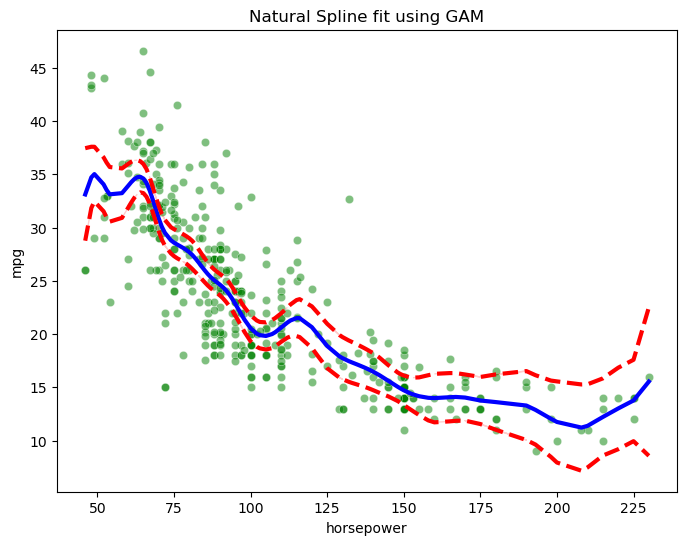

In [9]:
pred=gam.predict(X_spline)
conf_int=gam.confidence_intervals(X_spline)
fig,ax=plt.subplots(figsize=(8,6))
sns.scatterplot(x=X,y=y,ax=ax,color='green',alpha=0.5)
sns.lineplot(ax=ax,x=X,y=pred,color='blue',linewidth=3)
sns.lineplot(ax=ax,x=X,y=conf_int[:,0],color='red',linestyle='--',linewidth=3)
sns.lineplot(ax=ax,x=X,y=conf_int[:,1],color='red',linestyle='--',linewidth=3)
plt.title('Natural Spline fit using GAM');

### Multiple predictors

#### Quatitative Only

In [13]:
X=Auto[['displacement','horsepower']]
X_arr=np.asarray(X)

In [19]:
gam=LinearGAM(s_gam(0)+s_gam(1))
gam.fit(X_arr,y)
pred=gam.predict(X_arr)
conf_int=gam.confidence_intervals(X_arr)

In [26]:
conf_int.shape

(392, 2)

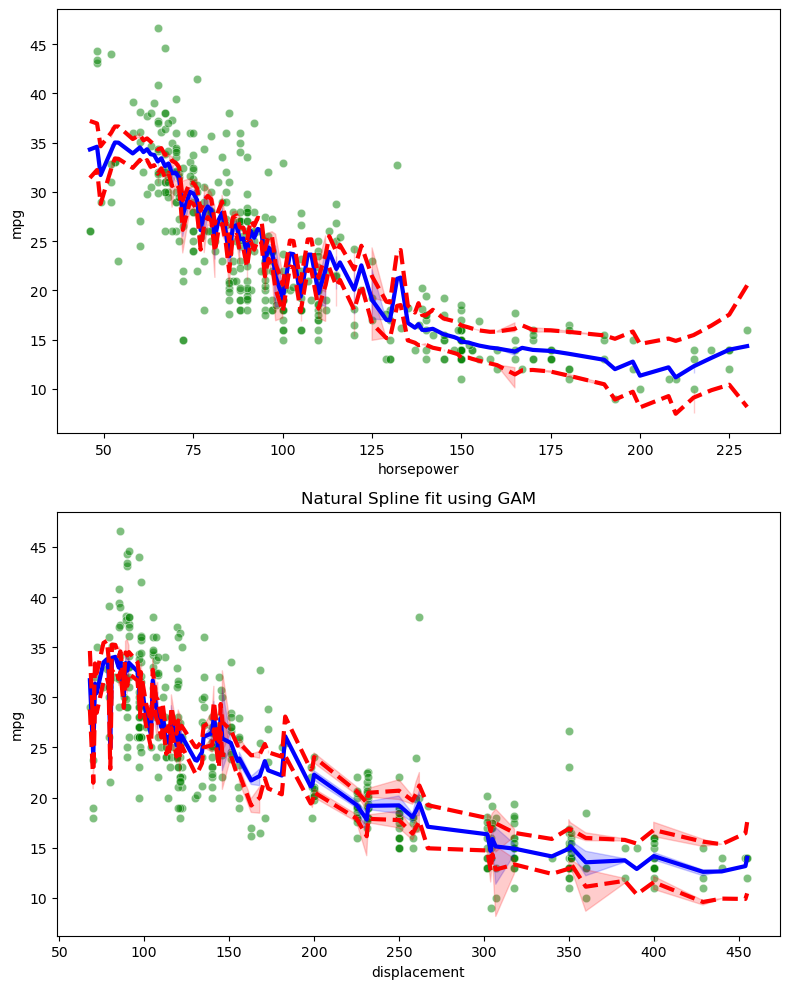

In [23]:
fig,ax=plt.subplots(nrows=2,figsize=(8,10))
sns.scatterplot(x=X['displacement'],y=y,ax=ax[1],color='green',alpha=0.5)
sns.lineplot(ax=ax[1],x=X['displacement'],y=pred,color='blue',linewidth=3)
sns.lineplot(ax=ax[1],x=X['displacement'],y=conf_int[:,0],color='red',linestyle='--',linewidth=3)
sns.lineplot(ax=ax[1],x=X['displacement'],y=conf_int[:,1],color='red',linestyle='--',linewidth=3)
sns.scatterplot(x=X['horsepower'],y=y,ax=ax[0],color='green',alpha=0.5)
sns.lineplot(ax=ax[0],x=X['horsepower'],y=pred,color='blue',linewidth=3)
sns.lineplot(ax=ax[0],x=X['horsepower'],y=conf_int[:,0],color='red',linestyle='--',linewidth=3)
sns.lineplot(ax=ax[0],x=X['horsepower'],y=conf_int[:,1],color='red',linestyle='--',linewidth=3)
plt.title('Natural Spline fit using GAM')
plt.tight_layout();

#### Qualitative + Quantitative

In [30]:
Auto.nunique()

mpg             127
cylinders         5
displacement     81
horsepower       93
weight          346
acceleration     95
year             13
origin            3
dtype: int64

In [34]:
Auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 24.6 KB


In [38]:
Auto['cylinders']=Auto['cylinders'].astype('category')
Auto['cylinders'].cat.codes

0      4
1      4
2      4
3      4
4      4
      ..
387    1
388    1
389    1
390    1
391    1
Length: 392, dtype: int8

In [71]:
X=Auto[['displacement','horsepower','cylinders']]
X_arr=np.column_stack([Auto['displacement'],Auto['horsepower'],Auto['cylinders']])#.cat.codes])
X_arr==np.asarray(X)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [72]:
gam=LinearGAM(s_gam(0)+s_gam(1,n_splines=7)+f_gam(2,lam=0))
gam.fit(X_arr,y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

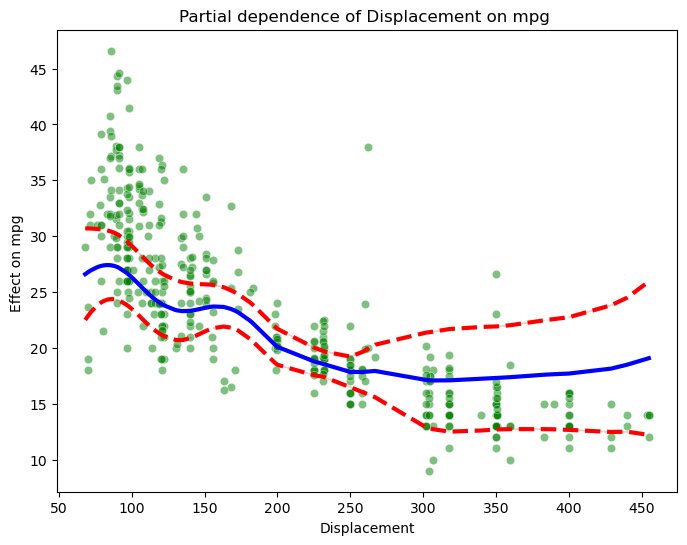

In [73]:
X_pred=X_arr.copy()
X_mean=X_arr.mean(axis=0)[np.newaxis,:]
X_pred[:,1:]=X_mean[:,1:]
pred=gam.predict(X_pred)
conf_int=gam.confidence_intervals(X_pred)
fig,ax=plt.subplots(figsize=(8,6))
sns.scatterplot(x=X_arr[:,0],y=y,ax=ax,color='green',alpha=0.5)
sns.lineplot(ax=ax,x=X_arr[:,0],y=pred,color='blue',linewidth=3)
sns.lineplot(ax=ax,x=X_arr[:,0],y=conf_int[:,0],color='red',linestyle='--',linewidth=3)
sns.lineplot(ax=ax,x=X_arr[:,0],y=conf_int[:,1],color='red',linestyle='--',linewidth=3)
ax.set_xlabel('Displacement')
ax.set_ylabel('Effect on mpg ')
ax.set_title('Partial dependence of Displacement on mpg ');

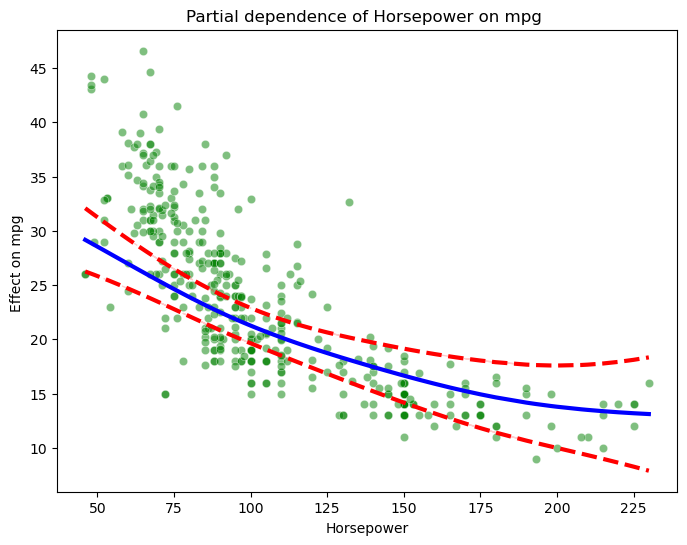

In [74]:
X_pred=X_arr.copy()
X_mean=X_arr.mean(axis=0)[np.newaxis,:]
X_pred[:,:]=X_mean[:,:]
X_pred[:,1]=X_arr[:,1]
pred=gam.predict(X_pred)
conf_int=gam.confidence_intervals(X_pred)
fig,ax=plt.subplots(figsize=(8,6))
sns.scatterplot(x=X_arr[:,1],y=y,ax=ax,color='green',alpha=0.5)
sns.lineplot(ax=ax,x=X_arr[:,1],y=pred,color='blue',linewidth=3)
sns.lineplot(ax=ax,x=X_arr[:,1],y=conf_int[:,0],color='red',linestyle='--',linewidth=3)
sns.lineplot(ax=ax,x=X_arr[:,1],y=conf_int[:,1],color='red',linestyle='--',linewidth=3)
ax.set_xlabel('Horsepower')
ax.set_ylabel('Effect on mpg ')
ax.set_title('Partial dependence of Horsepower on mpg ');

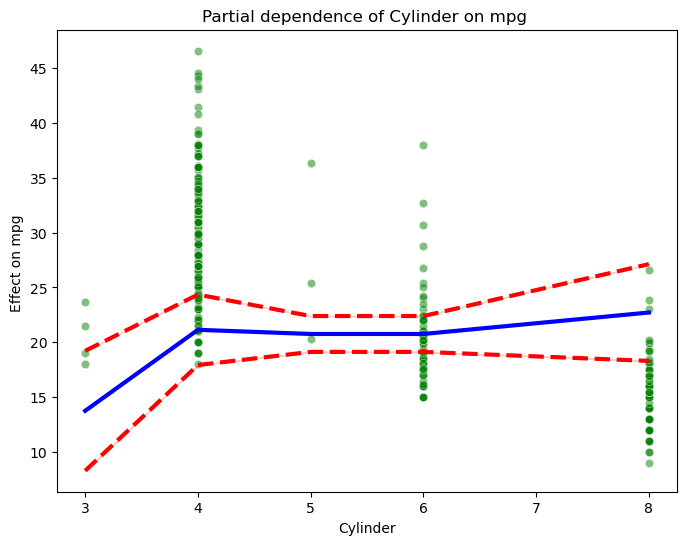

In [75]:
X_pred=X_arr.copy()
X_mean=X_arr.mean(axis=0)[np.newaxis,:]
X_pred[:,:]=X_mean[:,:]
X_pred[:,2]=X_arr[:,2]
pred=gam.predict(X_pred)
conf_int=gam.confidence_intervals(X_pred)
fig,ax=plt.subplots(figsize=(8,6))
sns.scatterplot(x=X_arr[:,2],y=y,ax=ax,color='green',alpha=0.5)
sns.lineplot(ax=ax,x=X_arr[:,2],y=pred,color='blue',linewidth=3)
sns.lineplot(ax=ax,x=X_arr[:,2],y=conf_int[:,0],color='red',linestyle='--',linewidth=3)
sns.lineplot(ax=ax,x=X_arr[:,2],y=conf_int[:,1],color='red',linestyle='--',linewidth=3)
ax.set_xlabel('Cylinder')
ax.set_ylabel('Effect on mpg ')
ax.set_title('Partial dependence of Cylinder on mpg ');

## Local Regression

In [108]:
X=Auto['horsepower']
X_arr=np.asarray(X)

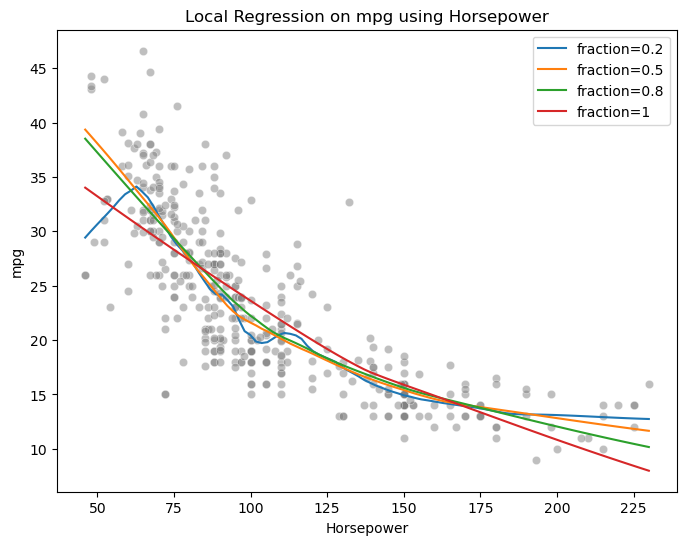

In [118]:
lowess=sm.nonparametric.lowess
span=[0.2,0.5,0.8,1]
X_grid=np.linspace(X_arr.min(),X_arr.max(),100)
fig,ax=plt.subplots(figsize=(8,6))
sns.scatterplot(x=X_arr,y=y,ax=ax,color='grey',alpha=0.5)
for sp in span:
    fitted=lowess(y,X_arr,frac=sp,xvals=X_grid)
    ax.plot(X_grid,fitted,label=f'fraction={sp}')
ax.set_xlabel('Horsepower')
ax.set_title('Local Regression on mpg using Horsepower')
plt.legend();

# Question 9

In [5]:
Boston=ISLP.load_data('Boston')
Boston[:2]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6


In [6]:
X=Boston['dis']
y=Boston['nox']
X_arr=np.asarray(X).reshape(-1,1)

## A

In [130]:
X_poly=MS([poly('dis',degree=3)]).fit_transform(Boston)
res=sm.OLS(y,X_poly).fit()
pred=res.get_prediction(X_poly)
conf_intr=pred.conf_int()

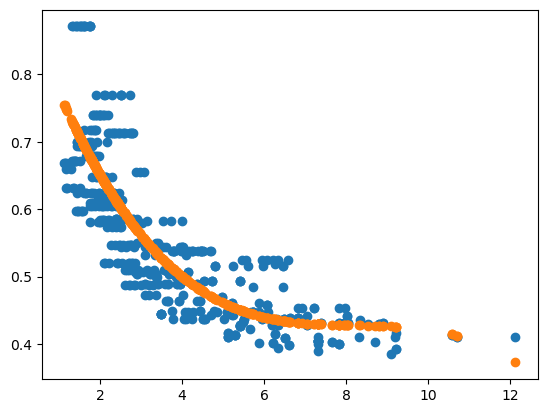

In [134]:
plt.scatter(X,y)
plt.scatter(X,pred.predicted_mean)

## B

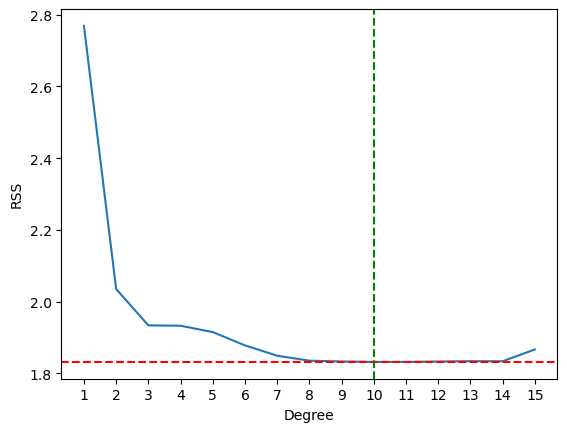

In [155]:
rss=[]
for i in range(1,16):
    lin_reg=LinearRegression()
    poly_f=PolynomialFeatures(degree=i)
    pipe=Pipeline([('poly_F',poly_f),('lin_reg',lin_reg)])
    pipe.fit(X_arr,y)
    pred=pipe.predict(X_arr)
    rss.append(np.sum((pred-y)**2))
rss
plt.plot(range(1,16),rss)
plt.xticks(range(1,16))
plt.axhline(min(rss),c='r',ls='--')
plt.axvline(rss.index(min(rss))+1,c='g',ls='--')
plt.xlabel('Degree')
plt.ylabel('RSS');

## C

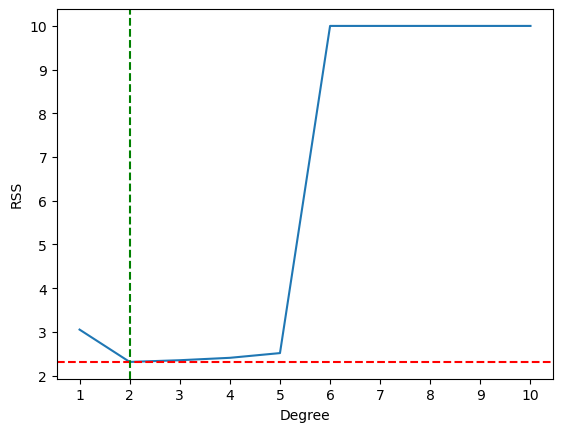

In [167]:
rss=[]
for i in range(1,11):
    lin_reg=LinearRegression()
    poly_f=PolynomialFeatures(degree=i)
    pipe=Pipeline([('poly_F',poly_f),('lin_reg',lin_reg)])
    rss.append(-cross_val_score(pipe,X_arr,y,scoring='neg_mean_squared_error').mean()*len(X_arr))
    # pipe.fit(X_arr,y)
    # pred=pipe.predict(X_arr)
    # rss.append(np.sum((pred-y)**2))
rss=np.clip(rss,min(rss),10)
plt.plot(range(1,11),rss)
plt.xticks(range(1,11))
plt.axhline(min(rss),c='r',ls='--')
plt.axvline((rss.argmin())+1,c='g',ls='--')
plt.xlabel('Degree')
plt.ylabel('RSS');

In [162]:
rss

[3.052247266912968,
 2.3126147500067558,
 2.35156793446804,
 2.4065959502096144,
 2.514643029147323,
 11.174161893300878,
 43.52158857620787,
 1223.505130531983]

## D

In [59]:
transformed = dmatrix("cr(Boston.dis, df=4)",{"Boston.dis":Boston.dis},return_type='dataframe')
res=sm.OLS(y,transformed).fit()
Boston_s=Boston.sort_values(by='dis')
dis_arr=np.asarray(Boston.dis.sort_values())
transformed = dmatrix("cr(Boston_s.dis, df=4)",{"Boston_s.dis":Boston_s.dis},return_type='dataframe')
pred=res.get_prediction(transformed)
bands=pred.conf_int()

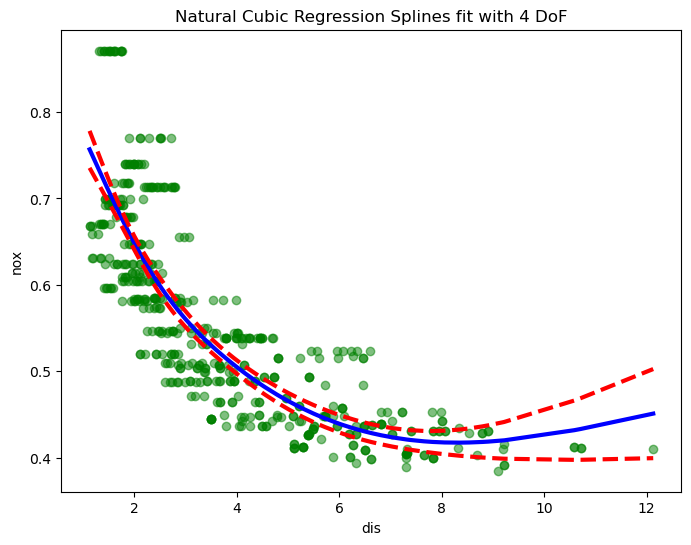

In [60]:
fig , ax = plt.subplots(figsize =(8 ,6))
ax.scatter(X ,y,facecolor='green',alpha =0.5)
for val , ls in zip([ pred.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
    ax.plot(Boston_s['dis'] , val , ls , linewidth =3)
ax.set_title('Natural Cubic Regression Splines fit with 4 DoF' )
ax.set_xlabel('dis')
ax.set_ylabel('nox');

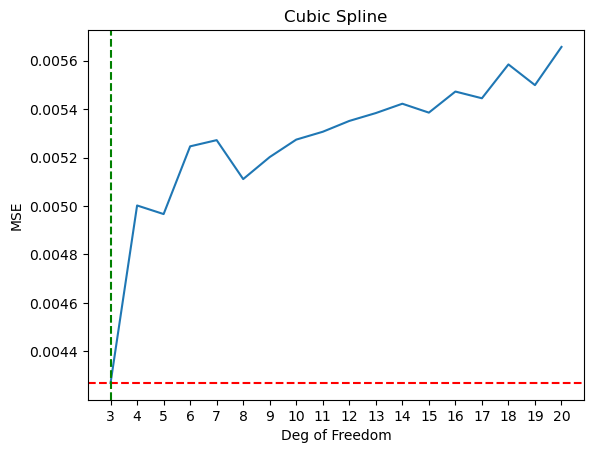

In [61]:
mse=[]
for i in range(3,21):  # The degrees of freedom can't be less than 3 in a cubic spline
    transformed = dmatrix("cr(Boston.dis, df=%i)" % i,{"Boston.dis":Boston.dis},
                          return_type='dataframe')  # Cubic spline basis representation
    lin = LinearRegression()
    lin.fit(transformed, y)
    mse.append(-cross_val_score(lin,transformed,y,scoring='neg_mean_squared_error').mean())
plt.plot(range(3,21),mse)
plt.xticks(range(3,21))
plt.axhline(min(mse),c='r',ls='--')
plt.axvline(mse.index(min(mse))+3,c='g',ls='--')
plt.xlabel('Deg of Freedom')
plt.ylabel('MSE')
plt.title('Cubic Spline');

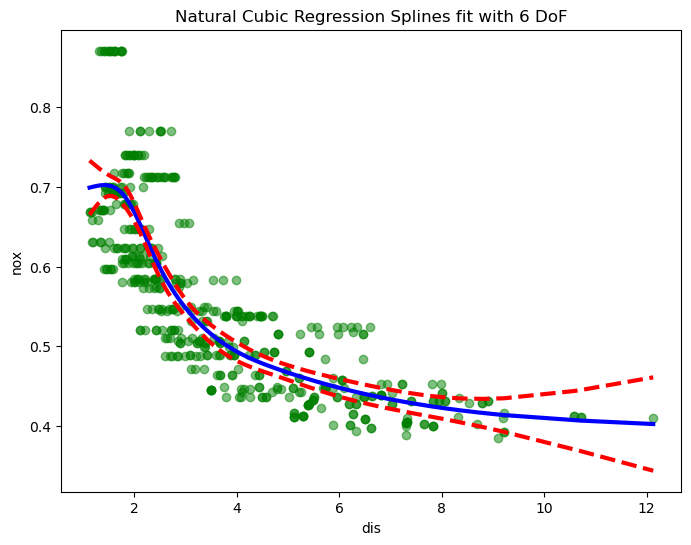

In [64]:
transformed = dmatrix("cr(Boston.dis, df=6)",{"Boston.dis":Boston.dis},return_type='dataframe')
res=sm.OLS(y,transformed).fit()
Boston_s=Boston.sort_values(by='dis')
transformed = dmatrix("cr(Boston_s.dis, df=6)",{"Boston_s.dis":Boston_s.dis},return_type='dataframe')
pred=res.get_prediction(transformed)
bands=pred.conf_int()
fig , ax = plt.subplots(figsize =(8 ,6))
ax.scatter(X ,y,facecolor='green',alpha =0.5)
for val , ls in zip([ pred.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
    ax.plot(Boston_s['dis'] , val , ls , linewidth =3)
ax.set_title('Natural Cubic Regression Splines fit with 6 DoF' )
ax.set_xlabel('dis')
ax.set_ylabel('nox');

# Question 10

## A

In [29]:
College=ISLP.load_data('College')
College[:2]

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56


In [30]:
College['Private_yes']=pd.get_dummies(College['Private'],drop_first=True).astype(int)
College.drop('Private',axis=1,inplace=True)
College[:2]

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_yes
0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1


In [7]:
College.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Apps         777 non-null    int64  
 1   Accept       777 non-null    int64  
 2   Enroll       777 non-null    int64  
 3   Top10perc    777 non-null    int64  
 4   Top25perc    777 non-null    int64  
 5   F.Undergrad  777 non-null    int64  
 6   P.Undergrad  777 non-null    int64  
 7   Outstate     777 non-null    int64  
 8   Room.Board   777 non-null    int64  
 9   Books        777 non-null    int64  
 10  Personal     777 non-null    int64  
 11  PhD          777 non-null    int64  
 12  Terminal     777 non-null    int64  
 13  S.F.Ratio    777 non-null    float64
 14  perc.alumni  777 non-null    int64  
 15  Expend       777 non-null    int64  
 16  Grad.Rate    777 non-null    int64  
 17  Private_yes  777 non-null    bool   
dtypes: bool(1), float64(1), int64(16)
memory usage: 10

In [31]:
X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(College.drop('Outstate',axis=1)
                                                                       ,College['Outstate'],test_size=0.2)

In [37]:
predictors=College.columns.drop('Outstate')
l1=len(predictors)
model=[]
Features=set()
Cp=float('inf')
for i in range(1,l1+1):
    print(i,Cp)
    for combo in itertools.combinations(predictors,i):
        if Features.issubset(set(combo)):
            # print(combo)
            # lin_reg=LinearRegression()
            X_=sm.add_constant(X_train[list(combo)])
            # lin_reg.fit(X_,y_train)
            # y_predicted=lin_reg.predict(X_)
            res=sm.OLS(y_train,X_).fit()
            RSS=res.ssr
            sigma_squared=res.scale
            cp=(RSS+(2*len(combo)*sigma_squared))/len(y_train)
            # mse=sklearn.metrics.mean_squared_error(y_train,y_predicted)
            if cp < Cp:
                Cp=cp
                lst=[]
                lst=[cp]
                lst.extend(list(combo))
                features=set(combo)
                # print(f'features={features}, set combo={set(combo)}')
    model.append(lst)
    Features=Features.union(features)
    print(f'Features={Features}')
    # if i==3: break 

1 inf
Features={'Expend'}
2 8791283.74986719
Features={'Expend', 'Private_yes'}
3 6424532.13867055
Features={'Expend', 'Room.Board', 'Private_yes'}
4 5209871.157232222
Features={'Expend', 'Room.Board', 'Private_yes', 'perc.alumni'}
5 4639319.76856609
Features={'Expend', 'Room.Board', 'Private_yes', 'PhD', 'perc.alumni'}
6 4363435.443920188
Features={'Expend', 'Room.Board', 'Private_yes', 'PhD', 'Grad.Rate', 'perc.alumni'}
7 4232393.786194881
Features={'Expend', 'Room.Board', 'Private_yes', 'PhD', 'Personal', 'Grad.Rate', 'perc.alumni'}
8 4213125.828575362
Features={'Expend', 'Room.Board', 'Private_yes', 'Terminal', 'PhD', 'Personal', 'Grad.Rate', 'perc.alumni'}
9 4197013.114287368
Features={'Expend', 'Room.Board', 'Accept', 'Private_yes', 'Terminal', 'PhD', 'Personal', 'Grad.Rate', 'perc.alumni'}
10 4184735.95862002
Features={'F.Undergrad', 'Room.Board', 'Accept', 'Personal', 'Grad.Rate', 'perc.alumni', 'Expend', 'Private_yes', 'Terminal', 'PhD'}
11 4104936.6098240446
Features={'F.Unde

In [42]:
pd.DataFrame(model[-1],index=['Cp',*range(1,13)]).T

,Cp,1,2,3,4,5,6,7,8,9,10,11,12
0,3987718.914197,Apps,Accept,Top10perc,F.Undergrad,Room.Board,Personal,PhD,Terminal,perc.alumni,Expend,Grad.Rate,Private_yes


## B

In [43]:
pd.DataFrame(model[-1],index=['Cp',*range(1,13)]).T

,Cp,1,2,3,4,5,6,7,8,9,10,11,12
0,3987718.914197,Apps,Accept,Top10perc,F.Undergrad,Room.Board,Personal,PhD,Terminal,perc.alumni,Expend,Grad.Rate,Private_yes


In [73]:
College=ISLP.load_data('College')
X=College[model[-1][1:-1]]
X['Private']=College.loc[:,'Private'].cat.codes
X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(X,College['Outstate']
                                                                       ,test_size=0.2)

C:\Users\SHANTANU SRIVASTAV\AppData\Local\Temp\ipykernel_712\2094862228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Private']=College.loc[:,'Private'].cat.codes


In [121]:
gam=LinearGAM(s_gam(0,n_splines=4)+s_gam(1,n_splines=4)+s_gam(2,n_splines=4)+s_gam(3,n_splines=4)+\
              s_gam(4,n_splines=4)+s_gam(5,n_splines=4)+s_gam(6,n_splines=4)+s_gam(7,n_splines=4)+\
              s_gam(8,n_splines=4)+s_gam(9)+s_gam(10)+f_gam(11))
gam.fit(X_train,y_train)        

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + f(11) + intercept,
   tol=0.0001, verbose=False)

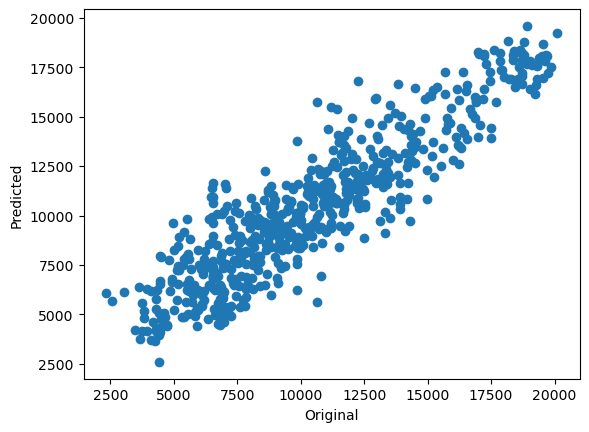

In [122]:
y_hat_train=gam.predict(X_train)
plt.scatter(y_train,y_hat_train)
plt.xlabel('Original')
plt.ylabel('Predicted');

## C

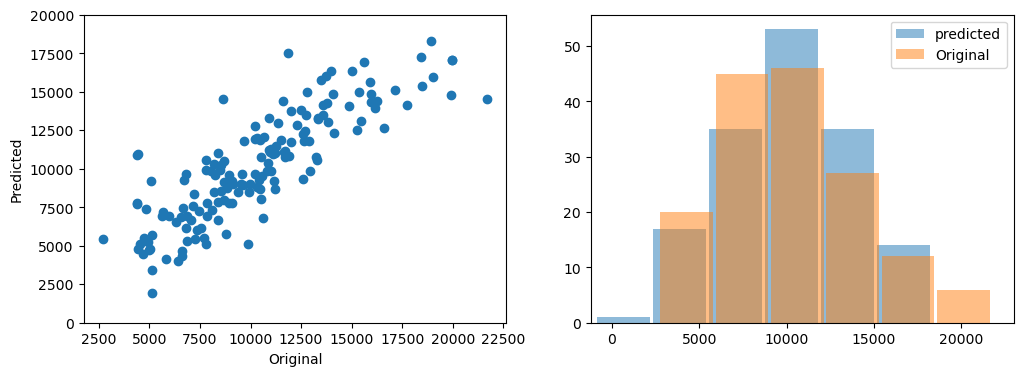

In [105]:
y_hat_test=gam.predict(X_test)
fig,ax=plt.subplots(ncols=2,figsize=(12,4))
ax[0].scatter(y_test,y_hat_test)
ax[0].set_ylim([0,20000])
ax[0].set_xlabel('Original')
ax[0].set_ylabel('Predicted')
ax[1].hist(y_hat_test,alpha=0.5,label='predicted',rwidth=0.95)
ax[1].hist(y_test,alpha=0.5,label='Original',rwidth=0.95,bins=6)
ax[1].set_xlim([-1200,23000])
plt.legend();

## D

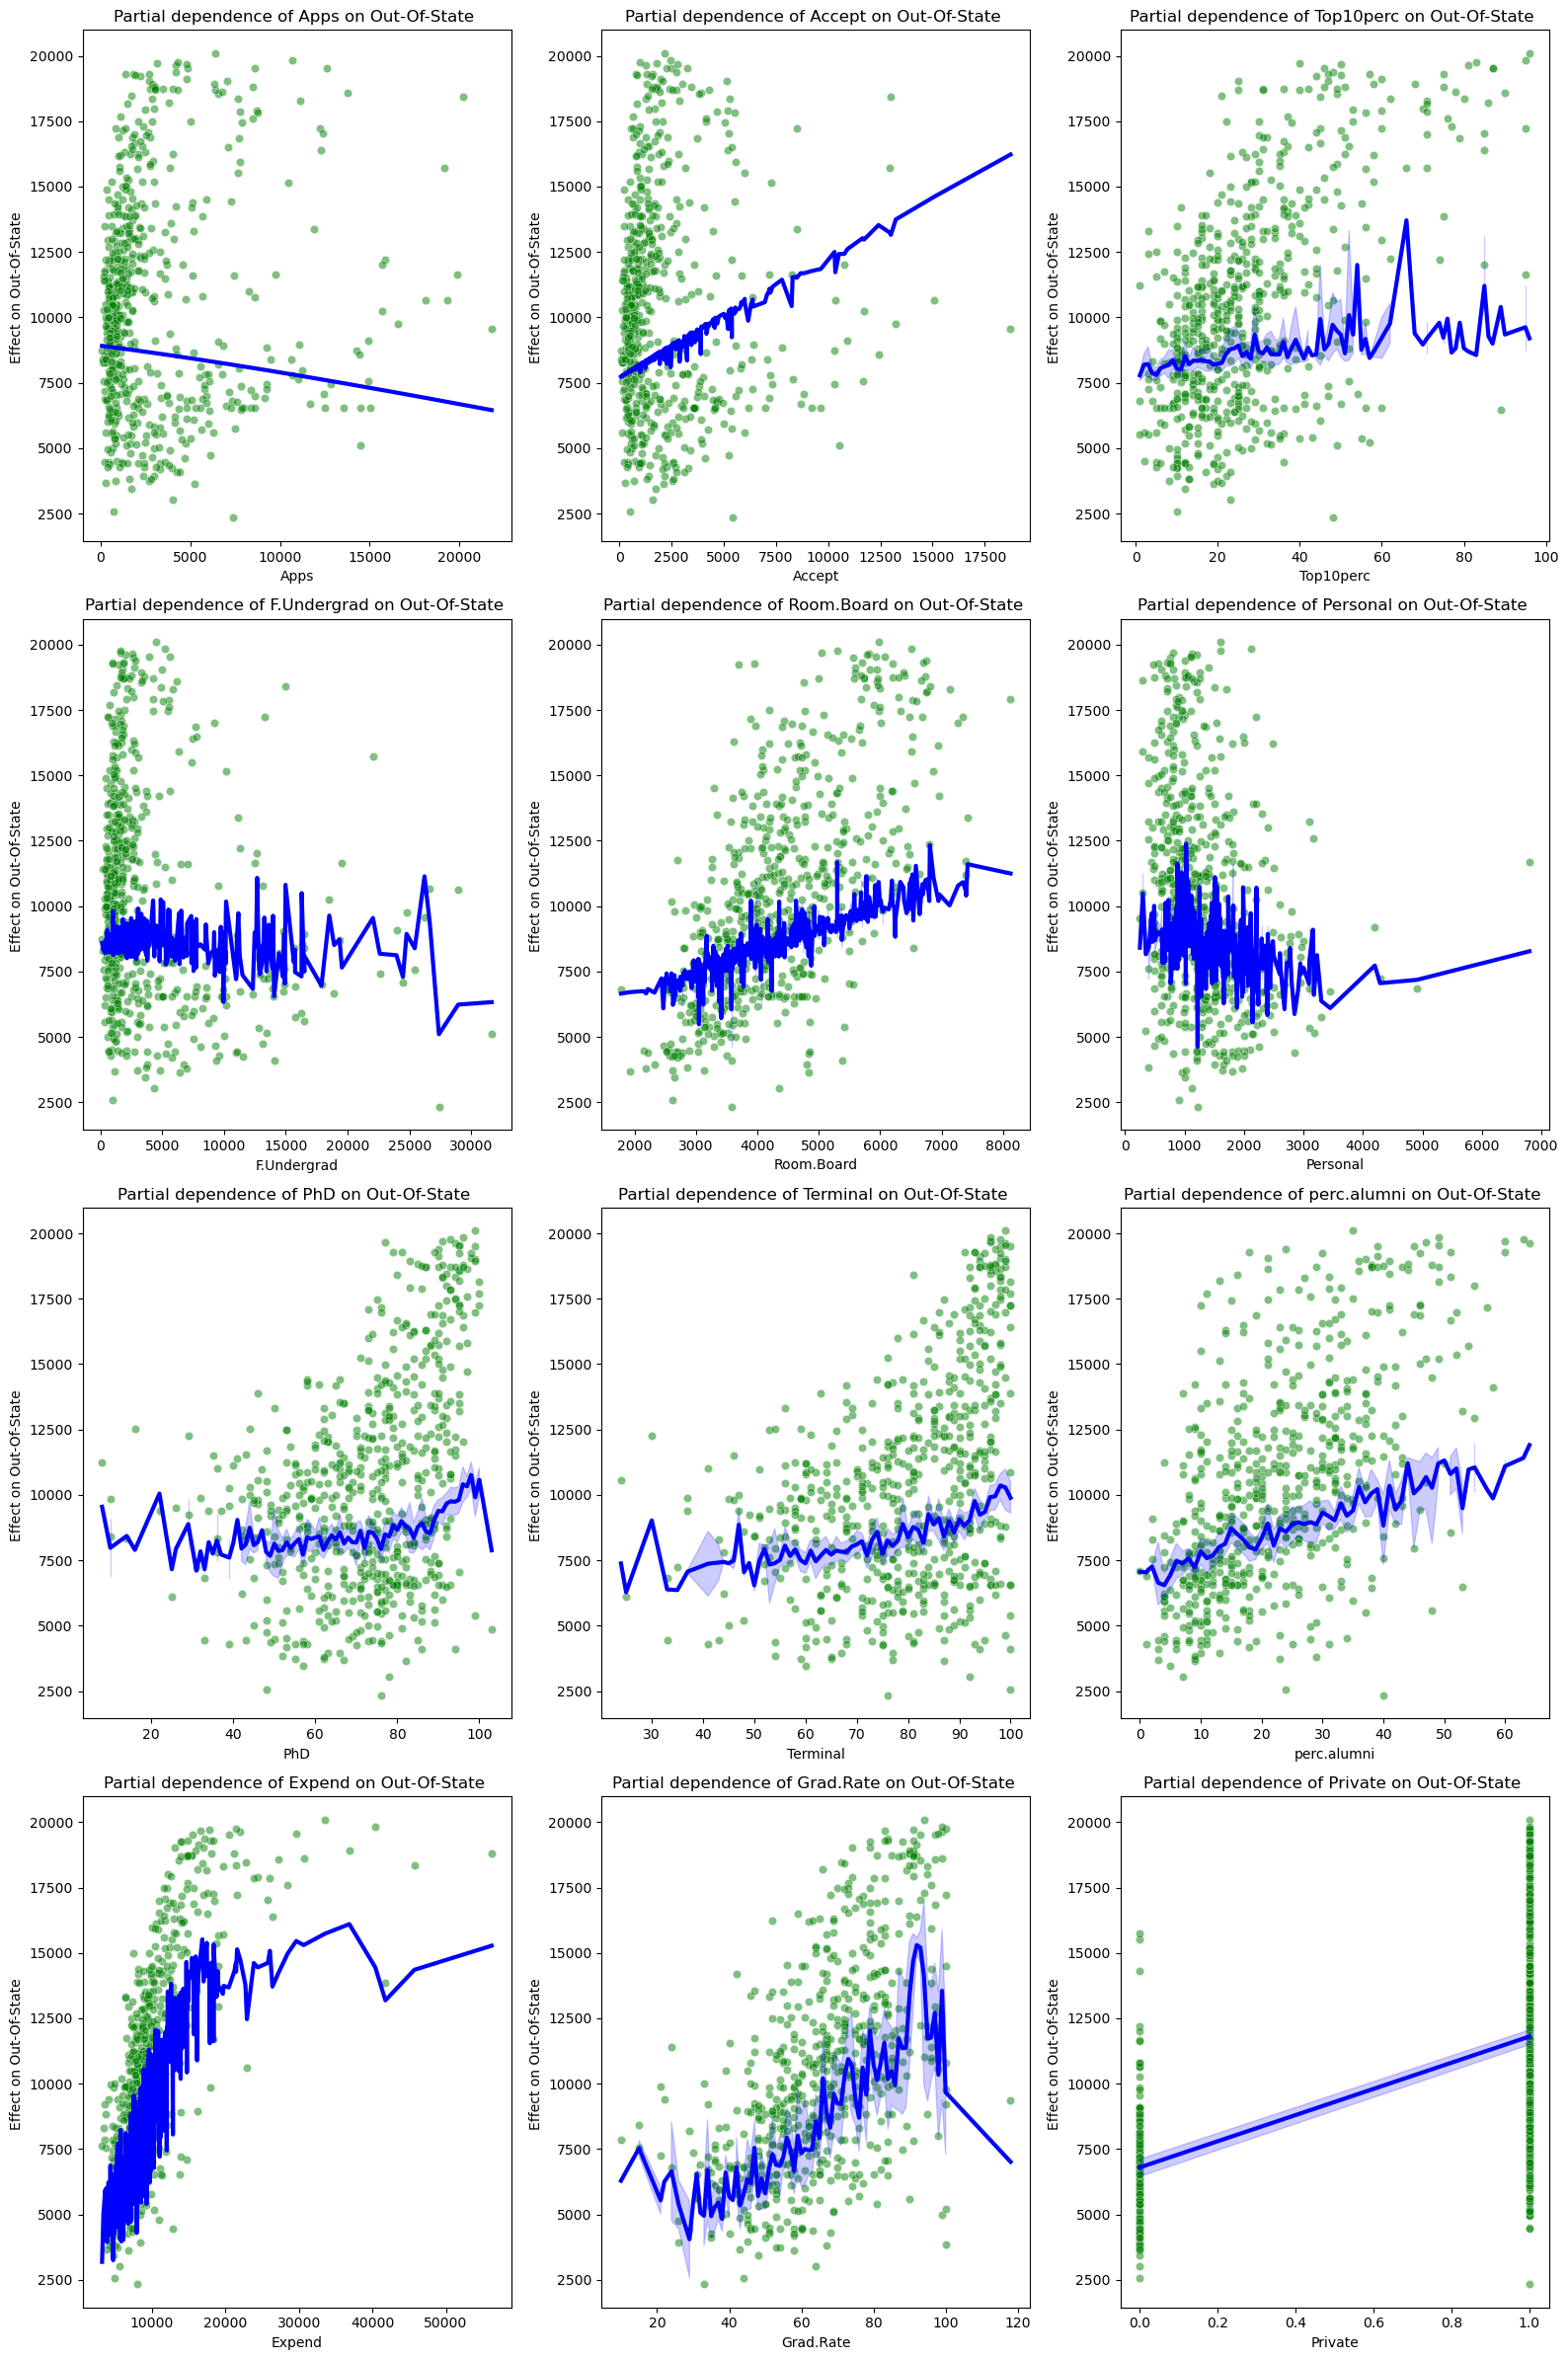

In [123]:
X_arr=np.asarray(X_train)
X_pred=X_arr.copy()
X_mean=X_arr.mean(axis=0)[np.newaxis,:]
X_pred[:,:]=X_mean[:,:]
fig,ax=plt.subplots(ncols=3,nrows=4,figsize=(16,24))
# print(ax)
for i,col in enumerate(X_train.columns):
    # print(i)
    X_pred[:,i]=X_arr[:,i]
    pred=gam.predict(X_pred)
    # conf_int=gam.confidence_intervals(X_pred)
    # fig,ax=plt.subplots(figsize=(8,6))
    a,b=divmod(i,3)
    sns.scatterplot(x=X_arr[:,i],y=y_train,ax=ax[a,b],color='green',alpha=0.5)
    sns.lineplot(ax=ax[a,b],x=X_arr[:,i],y=pred,color='blue',linewidth=3)
    # sns.lineplot(ax=ax[a,b],x=X_arr[:,i],y=conf_int[:,0],color='red',linestyle='--',linewidth=3)
    # sns.lineplot(ax=ax[a,b],x=X_arr[:,i],y=conf_int[:,1],color='red',linestyle='--',linewidth=3)
    ax[a,b].set_xlabel(f'{col}')
    ax[a,b].set_ylabel('Effect on Out-Of-State ')
    ax[a,b].set_title(f'Partial dependence of {col} on Out-Of-State ')
plt.tight_layout();

# Question 11

In [110]:
X1=np.random.chisquare(df=3,size=100)
X2=np.random.randn(100)*10
eps=np.random.randn(100)

In [111]:
pd.DataFrame([X1,X2,eps]).T.corr()

,0,1,2
0,1.000000,0.017575,-0.003709
1,0.017575,1.000000,0.137017
2,-0.003709,0.137017,1.000000


In [112]:
Y=-25*X1+7*X2+eps

In [113]:
X=np.vstack((X1,X2)).T
X.shape

(100, 2)

In [114]:
res=sm.OLS(Y,X1).fit()
res.params

array([-24.55510313])

In [115]:
def simple_reg(outcome,feature):
    X=sm.add_constant(feature)
    res=sm.OLS(outcome,X).fit()
    return res.params

In [116]:
beta1=15

In [117]:
outcome=Y-(beta1*X1)
feature=X2+eps
beta_naught,beta2=simple_reg(outcome,feature)
beta_naught,beta2

(-127.4952569595599, 6.67178370724559)

In [118]:
outcome=Y-(beta2*X2)
feature=X1+eps
beta_naught,beta1=simple_reg(outcome,feature)
beta_naught,beta1

(-12.783379391301914, -21.31631881817948)

In [119]:
beta1=15
b0=[]
b1=[]
b2=[]
for i in range(1000):
    if i%2:
        outcome=Y-(beta2*X2)
        feature=X1+eps
        beta_naught,beta1=simple_reg(outcome,feature)
        b0.append(beta_naught);b1.append(beta1);b2.append(beta2)
    else:
        outcome=Y-(beta1*X1)
        feature=X2+eps
        beta_naught,beta2=simple_reg(outcome,feature)
        b0.append(beta_naught);b1.append(beta1);b2.append(beta2)

In [120]:
len(b0)

1000

In [133]:
df=pd.DataFrame(data=[b0,b1,b2],index=['intercept','beta1','beta2'],columns=range(1,1001)).T
# df.insert(loc=0,column='x',value=range(1,1001))
df

,intercept,beta1,beta2
1,-127.495257,15.000000,6.671784
2,-12.783379,-21.316319,6.671784
3,-11.456361,-21.316319,6.831913
4,-12.697982,-21.353929,6.831913
5,-11.336187,-21.353929,6.832079
...,...,...,...
996,-12.697893,-21.353968,6.832079
997,-11.336062,-21.353968,6.832079
998,-12.697893,-21.353968,6.832079
999,-11.336062,-21.353968,6.832079


intercept   -11.336062
beta1       -21.353968
beta2         6.832079
Name: 51, dtype: float64


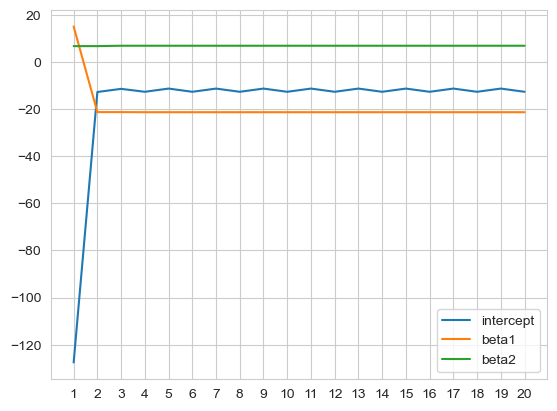

In [136]:
print(df.iloc[50])
sns.set_style("whitegrid")
df.iloc[:20].plot()
plt.xticks(range(1,21,1));

In [123]:
X=sm.add_constant(X)
sm.OLS(Y,X).fit().params

array([ -0.04347932, -25.00246501,   7.01476501])

# Question 12

In [115]:
'''each column in X is a predictor'''
X=np.random.chisquare(df=23,size=(100,100))
coef=np.random.randint(-20,34,size=(1,100))
eps=np.random.randn(100)[:,np.newaxis]
X_b=X*coef
Y=(X*coef).sum(axis=1,keepdims=False)

In [116]:
coef
X=pd.DataFrame(X)
Y.shape

(100,)

In [117]:
initial_estimates=np.random.randint(-200,340,size=100)

In [118]:
a=np.array((1,2,3,4,5,6,7))
b=np.array((10,20,30,40,50,60,70))
i=0
np.hstack((a[:i],b[i],a[i:]))
np.delete(a,1,0),a

(array([1, 3, 4, 5, 6, 7]), array([1, 2, 3, 4, 5, 6, 7]))

In [119]:
b=0
(X[b]*initial_estimates[b]).shape
(Y-(X[b]*initial_estimates[b])).shape

(100,)

In [120]:
err=[]
for i in range(1000):
    _,b=divmod(i,100)
    x=X.drop(b,axis='columns')
    x=x*np.delete(initial_estimates,b)+eps
    x=sm.add_constant(x)
    y=Y-(X[b]*initial_estimates[b])
    # print(x)
    intrcept,*coeff=sm.OLS(y,x).fit().params
    # print(intrcept,coeff,initial_estimates)
    initial_estimates=np.hstack((coeff[:b],initial_estimates[b],coeff[b:]))
    # print(initial_estimates)
    err.append(np.square(initial_estimates[np.newaxis,:]-coef).mean())

In [123]:
len(err)
err

[485.21508266736936,
 11110.393971615165,
 415.67436054330346,
 475401.54791961797,
 2630.274247254572,
 620775.2763371903,
 4312.489150576226,
 102189.89783993315,
 236451475.83764556,
 7114.929368454141,
 8243439.353864075,
 257386.06323995785,
 744393.4657210745,
 108385.31986849375,
 10628535.043947645,
 42077207.36504383,
 272945.7514385526,
 210430442960.7289,
 15659.598261192556,
 774036284.8945483,
 16220798.230273377,
 29163356.81879267,
 16071987.534202646,
 37445876.59583949,
 10367259.648006909,
 90919059.36548562,
 10504289.488847068,
 39925279.2767855,
 10492352.821342925,
 18707023.346281957,
 11051767.84602166,
 537180341.5399824,
 28417377067.158047,
 30039506639409.387,
 26754779206.356026,
 264247363.3400199,
 11445720.612779679,
 269432025.0047549,
 585519465793.5323,
 2447318.452612939,
 15390360723.641855,
 549411.2167981247,
 3101737526.632288,
 21350075.32003007,
 2434125272.9908996,
 453754.48289873166,
 3311037477514.0977,
 2947.927199825054,
 1082676179702.46

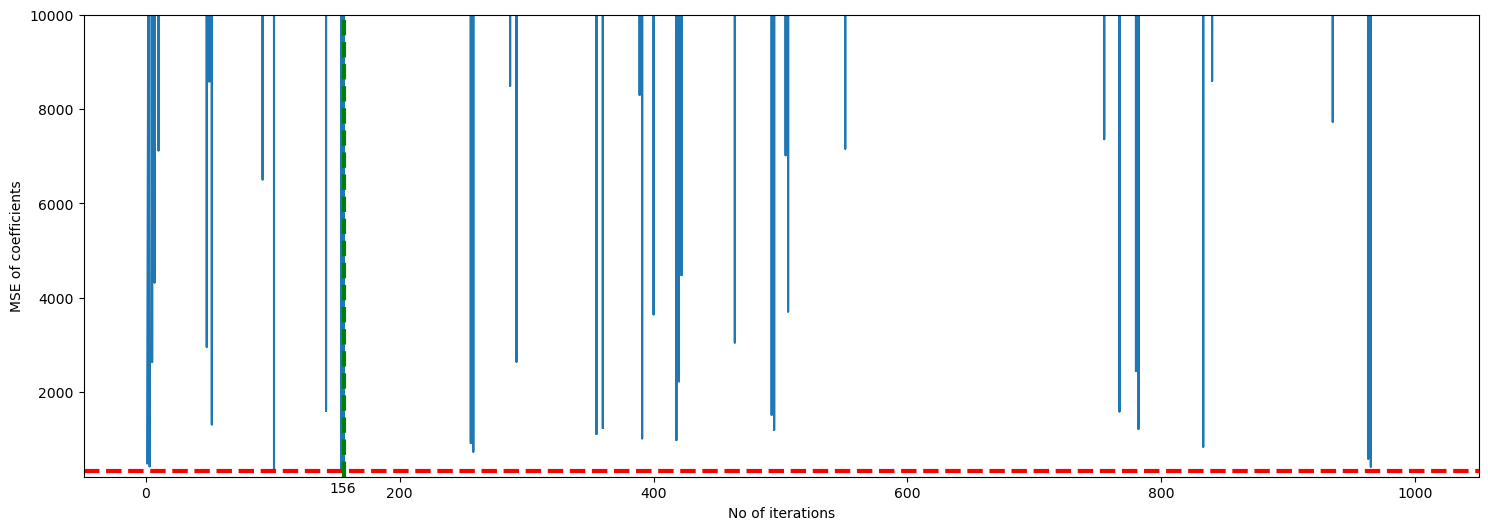

In [151]:
plt.figure(figsize=(18,6))
plt.plot(range(1,1001),err)
plt.ylim([200,10000])
plt.xlabel('No of iterations')
plt.ylabel('MSE of coefficients')
plt.axhline(min(err),c='r',ls='--',lw=3)
plt.axvline(err.index(min(err))+1,c='g',ls='--',lw=3)
plt.text(err.index(min(err))-10,-120,s=err.index(min(err))+1);